In [42]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from shapely import Point, Polygon
from pyproj import Proj

from utils import read_jgw_file, utm_to_lat_long

In [43]:
def mask_to_coordinates(image, mask, transformation, projection='utm'):
    """
    compute and convert pixel to gps coordinates
    """
    # unpack transformation params
    x_top_left = transformation['C']
    y_top_left = transformation['F']
    pixel_size_x = transformation['A']
    pixel_size_y = transformation['E']
    # find contours from the binary mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # compute pixel coords of each parking stall and convert it to GPS coords
    polygons = []
    vertices = []
    for contour in contours:
        contour = contour.reshape(-1, 2)
        v = []
        p = []
        bbox = cv2.boundingRect(contour)
        bb_x, bb_y, bb_w, bb_h = bbox
        bb_corners = [(bb_x, bb_y), (bb_x + bb_w, bb_y), (bb_x + bb_w, bb_y + bb_h), (bb_x, bb_y + bb_h)]
        #print(contour[np.argmax(contour[:, 0])])
        max_x = False
        min_x = False
        max_y = False
        min_y = False
        found = False
        for px, py in contour:
            #if (bb_x <= px <= bb_x + bb_w) and (bb_y <= py <= bb_y + bb_h):  
            if px == contour[np.argmax(contour[:, 0])][0] and max_x == False:
                found = True
                max_x = True
            elif px == contour[np.argmin(contour[:, 0])][0] and min_x == False:
                found = True
                min_x = True
            elif py == contour[np.argmax(contour[:, 1])][1] and max_y == False:
                found = True
                max_y = True
            elif py == contour[np.argmin(contour[:, 1])][1] and min_y == False:
                found = True
                min_y = True
            
            if found:
                x = x_top_left + (px * pixel_size_x)
                y = y_top_left + (py * pixel_size_y)

                if projection == 'utm':
                    lon, lat = utm_to_lat_long(easting=x, norting=y, zone=14, ellps='WGS84', hemisphere='N')
                    p.append(Point(lon, lat))
                else:
                    p.append(Point(x, y))
                v.append((x, y))
                found = False
            
        if len(p) > 3:        
            polygons.append(Polygon([(point.x, point.y) for point in p]))
            vertices.append(v)
        
    return polygons, vertices

In [44]:
transformation = read_jgw_file("media/raster_to_vector/georeference.jgw")

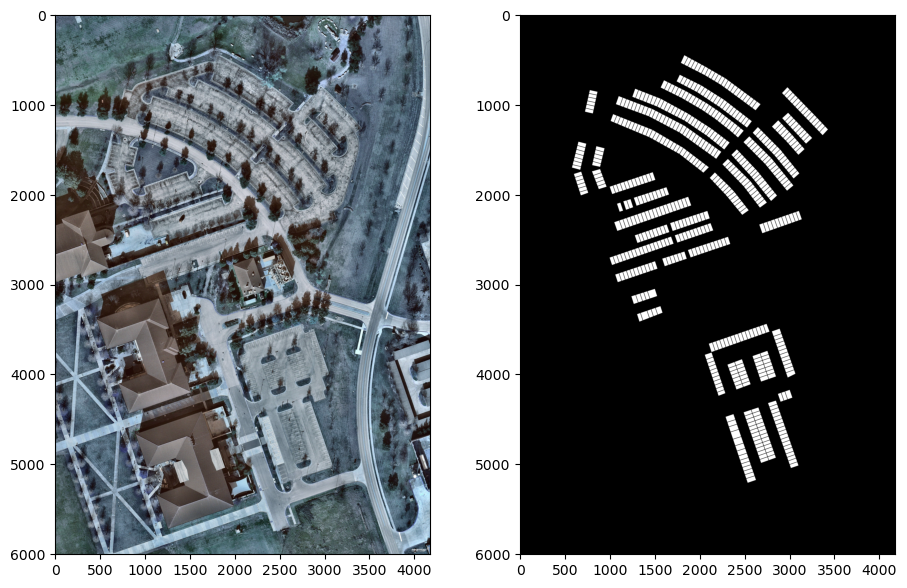

In [45]:
image = cv2.imread("media/raster_to_vector/satellite.jpg", cv2.COLOR_BGR2RGB)
mask = cv2.imread("media/raster_to_vector/mask.png", 0)

plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(mask, 'gray')

plt.show()


In [46]:
polygons, vertices = mask_to_coordinates(image, mask, transformation, projection='')

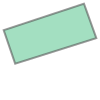

In [47]:
polygons[1]

In [48]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(geometry=polygons, crs='epsg:3857')

In [49]:
gdf.head()

,geometry
0,"POLYGON ((-10870729.847 3576629.008, -10870736..."
1,"POLYGON ((-10870731.041 3576632.218, -10870737..."
2,"POLYGON ((-10870732.011 3576635.204, -10870738..."
3,"POLYGON ((-10870733.131 3576638.190, -10870739..."
4,"POLYGON ((-10870694.539 3576640.653, -10870700..."


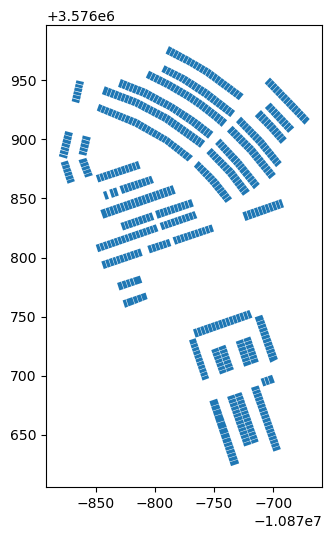

In [50]:
gdf.plot(figsize=(6, 6))
plt.show()

In [51]:
#gdf = gdf.set_crs('EPSG:4326', allow_override=True)
gdf.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [52]:
geojson = gdf.to_json()

In [53]:
#gdf.to_file("media/raster_to_vector/output.geojson", driver="GeoJSON")
gdf.to_file("media/raster_to_vector/output.shp")


In [54]:
#gdf.to_csv('data/parking.csv', index=False)

In [57]:
import folium
import pyproj

# Load the shapefile using geopandas
gdf = gpd.read_file('media/raster_to_vector/output.shp')

# Define the projection transformers
projector = pyproj.Transformer.from_crs('epsg:3857', 'epsg:4326', always_xy=True)

# Calculate the center coordinates in EPSG:4326
center_lon, center_lat = projector.transform(gdf.bounds.minx.mean(), gdf.bounds.miny.mean())

# Create a folium map centered at the calculated location, using EPSG:4326 coordinates
m = folium.Map(location=[center_lat, center_lon], zoom_start=18, crs='EPSG3857')

# Add satellite
folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True
       ).add_to(m)

# Add the shapefile to the map
folium.GeoJson(gdf, name='parking_layout').add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Display the map
m

In [58]:
m.save('../../tsdinh442.github.io/media/html/geospatial_analysis/raster_to_vector.html')